# Benchmark

## *Table of contents*
* *Setup Phase*
	1. Import libraries and queries
	2. Showing all the available queries
	3. Query selection

* *Evaluation Phase*
	1. Precision at Standard Recall Levels for query Q
	2. Interpolated Average Precision (IAP) at Standard Recall Leveles
	3. R-Precision
	4. Mean Average Precision (MAP)
	5. F-Measure & E-Measure 

## *Setup phase*

### Import libraries and queries

In [1]:
import os
import json
from whoosh.scoring import BM25F
from doc2vec.doc2vec_model import Doc2VecModel
from sentiment.sentiment_model import SentimentWeightingModel, AdvancedSentimentWeightingModel, SentimentWeightingModelWeightedAverage, AdvancedSentimentWeightingModelWeightedAverage

import seaborn as sns
import pandas as pd

# file containing benchmark queries
file_path = os.path.join("evaluation", "queries.json")

# loades the queries
with open(file_path) as f:
    queries = json.load(f)


# Models that need to be tested. 
models = [
	(BM25F(), "BM25F"),
 	(Doc2VecModel(), "Doc2Vec"),
	(SentimentWeightingModel(), "Base Sentiment"),
	(AdvancedSentimentWeightingModel(), "Advanced Sentiment" ),
	(SentimentWeightingModelWeightedAverage(), "Base Sentiment Weighted Average Based"),
	(AdvancedSentimentWeightingModelWeightedAverage(), "Advanced Sentiment Weighted Average Based")
]

### Showing all the available queries

In [2]:
indexes, uin = [i for i in range(len(queries))], [k["UIN"] for k in queries]
print('ID \t UIN')
print('\n'.join([f"{x[0]} \t {x[1]}" for x in list(zip(indexes, uin))]))

ID 	 UIN
0 	 I need an apartment near st james park
1 	 enjoyable double room where i could stay with my dog.
2 	 I'm a student looking for a budget-friendly hostel in Kensington or Westminster. I don't care about having all kind of amenities.
3 	 I'm looking for a luxurious apartment in Kensington for a family of four, with two bathrooms and a beautiful view.
4 	 I need a cheap place in Camden that allows dogs, ideally with a minimum rating of 3 stars.
5 	 I'm searching a place with a beautiful view. I need a bright apartment in Lambeth for two people
6 	 My partner and I are looking for a romantic getaway. We want an apartment rated at least 4 stars.
7 	 I need a budget-friendly room in Hackney, with access to a shared bathroom and a rating of at least 2 stars.
8 	 We are a group of friends looking for a large apartment in Tower Hamlets with at least 3 beds and 2 bathrooms. Budget is up to â‚¬500 per night.
9 	 I'm searching a creepy and old place for an Halloween party. Looking for 

### Query selection

Query selection occurs by assigning a value to the variable ***examined_q*** within the available range shown above.

In [3]:
try:
    examined_q = 10
    # 2 3 5 6 7 9
    #! la 10 funzione bene
    print("User Information Need: " + queries[examined_q]["UIN"])
except IndexError as e:
    print("index not valid")

User Information Need: I need a bright studio in London City for a work trip, rated at least 4 stars


Subsequently, an object Benchmark is created.  

In [4]:
from evaluation.functions import Benchmark

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Suppress the warning 

b = Benchmark(queries[examined_q])


## *Evaluation Phase*

### Precision at Standard Recall Levels for query Q

Given Natural Recall Values and Precision Values, Precision at Standard Recall Levels is Computed using 

$P(r_j)=\text{max}_{r_j\le r\le r_{j+1}}P(r)$

Standard Measures is obtained by considering 11 recall points where precision is measured: 0%, 10%, 20%, … , 100%. 

[16485583, 37386139, 37385778, 12820614, 46368632, 42081797, 36137939, 53711693, 587416140805762321, 49186160, 628051766302032972, 46233904, 10064124, 701383642414691619, 53471916, 20379818, 47846305, 49332642, 49189978, 46457459]
[16485583, 46368632, 12820614, 36137939, 46233904, 37386139, 554915867550987554, 701383642414691619, 37385778, 10064124, 42081840, 8379886, 5657722, 27626519, 19538761, 53711693, 17564185, 587416140805762321, 50694341, 49332642]
[37385778, 16485583, 37386139, 12820614, 46233904, 46368632, 42081797, 628051766302032972, 53471916, 53711693, 701383642414691619, 36137939, 46457459, 19538761, 27626519, 20379818, 42081759, 47846305, 587416140805762321, 42081840]
[37385778, 16485583, 37386139, 46233904, 42081797, 53471916, 46368632, 19538761, 46457459, 27626519, 12820614, 42081759, 42081840, 20379818, 47846305, 49332642, 53711693, 17564185, 36137939, 50694341]
[37385778, 16485583, 37386139, 12820614, 46368632, 42081797, 628051766302032972, 46233904, 53711693, 3613793

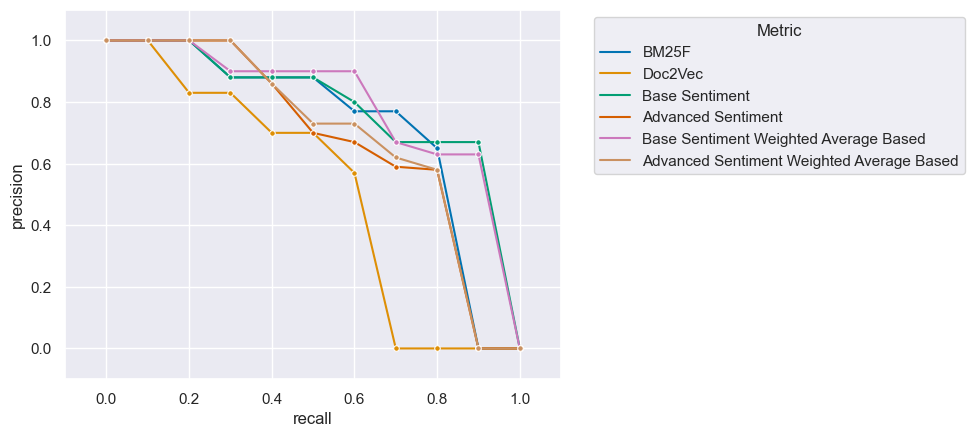

In [5]:
# define axes' names
axes = ["recall", "precision"]

# create a dataframe for Seaborn
df = pd.DataFrame()

for model, model_name in models:
    result = b.getResults(20, model)
    print(result)
    # get precision at standard recall values over list of result
    SRLValues = b.getSRLValues(
        b.getPrecisionValues(result),
        b.getRecallValues(result)
    )
    
    # tmp dataframe concatenated to the main one
    dfB = pd.DataFrame(SRLValues, columns = axes)
    dfB["Version"] = f'{model_name}'
    
    df = pd.concat([df, dfB])

sns.set_theme()


# plot the line graph
pltP = sns.lineplot(data = df, x = 'recall', y = 'precision', marker='o', markersize=4, 
            hue="Version", palette="colorblind")
pltP.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# set fixed axes, the semicolon suppress the output
pltP.set_xlim([-0.1, 1.1]);
pltP.set_ylim([-0.1, 1.1]);
    

### Average Precision At Standard Recall Levels

In [6]:
IAPatSRL = {}

for q in queries:
    tmpB = Benchmark(q)
    for model, model_name in models:
        result = tmpB.getResults(20, model)
        SRLValues = tmpB.getSRLValues(
            tmpB.getPrecisionValues(result),
            tmpB.getRecallValues(result)
            )
        IAPatSRL.setdefault(model_name, []).append(
			SRLValues
		)

'8946230'
'11621478'
'TermRange' object has no attribute 'text'
'TermRange' object has no attribute 'text'
'TermRange' object has no attribute 'text'
'TermRange' object has no attribute 'text'
'TermRange' object has no attribute 'text'
'TermRange' object has no attribute 'text'
'7661166'
'1346531'


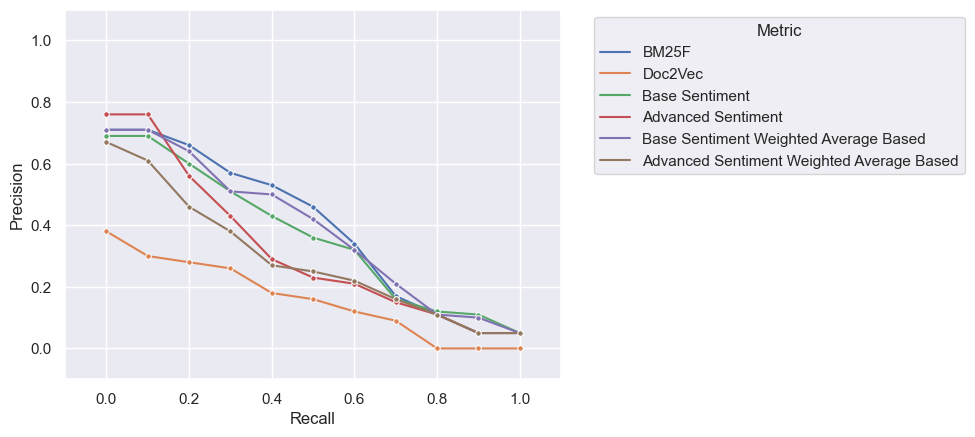

In [7]:
from functools import reduce
import matplotlib as plt
meansDict = {}

for k,v in IAPatSRL.items():
    # Trasporre la lista di liste per ottenere gli elementi corrispondenti
    transposed = list(zip(*v))

    # Calcolare la media dei secondi elementi delle tuple utilizzando reduce
    means = []
    for tuples in transposed:
        mean = reduce(lambda acc, t: acc + t[1], tuples, 0) / len(tuples)
        means.append((tuples[0][0], round(mean,2)))
    
    meansDict[k] = means


# Convert the dictionary to a DataFrame
df_list = []

for key, value in meansDict.items():
    for x, y in value:
        df_list.append({'Version': key, 'Recall': x, 'Precision': y})

df = pd.DataFrame(df_list)

# Plotting with Seaborn
pltIAPatSRL = sns.lineplot(data=df, x='Recall', y='Precision', hue='Version', marker='o', markersize=4)
pltIAPatSRL.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left');

pltIAPatSRL.set_xlim([-0.1, 1.1]);
pltIAPatSRL.set_ylim([-0.1, 1.1]);


### Interpolated Average Precision (IAP) at Standard Recall Leveles

Interpolated Average Precision for each query is computed using 

$\sum_{r=0}^{n} \frac{P_q(r)}{n}$

where $P_q(r)$ is the interpolated precision at the level $r$, for n+1 standard recall levels.

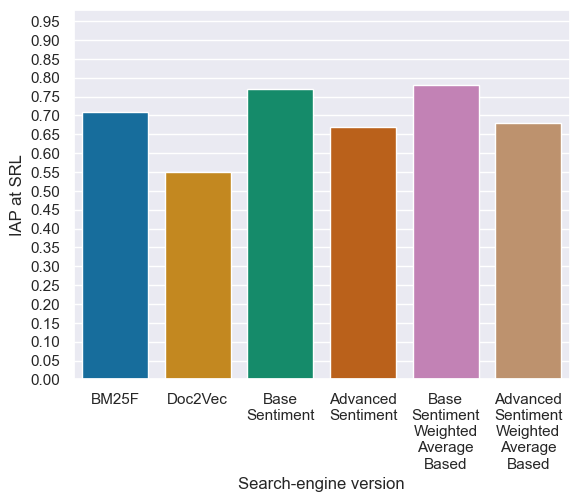

In [8]:
from matplotlib.ticker import MultipleLocator
import textwrap

versions = [] 
AvPr_values=[]

for model, model_name in models:
    result = b.getResults(20, model)
    SRLValues = b.getSRLValues(
        b.getPrecisionValues(result),
        b.getRecallValues(result)
    )
    
    AvPr_values.append(b.getIapAvgPrecision(SRLValues))
    
    versions.append(textwrap.fill(model_name, width=10,
                    break_long_words=True))
    
# plot the average precisi+ons
# apply the default theme
sns.set_theme()


# create a dataframe for Seaborn
df = pd.DataFrame({"Search-engine version": versions, "IAP at SRL": AvPr_values})

# plot the bar graph
pltAvPr = sns.barplot(data = df, x = "Search-engine version", y = 'IAP at SRL',palette="colorblind")


# set fixed axes, the semicolon suppress the output
pltAvPr.set_ylim([0.0, max(AvPr_values)+0.20]); # set y-axis    
pltAvPr.yaxis.set_major_locator(MultipleLocator(0.05))

### R-Precision

Calculate how many relevant documents I have returned compared to the ideal case in which in the first $n$ documents are all relevants. 

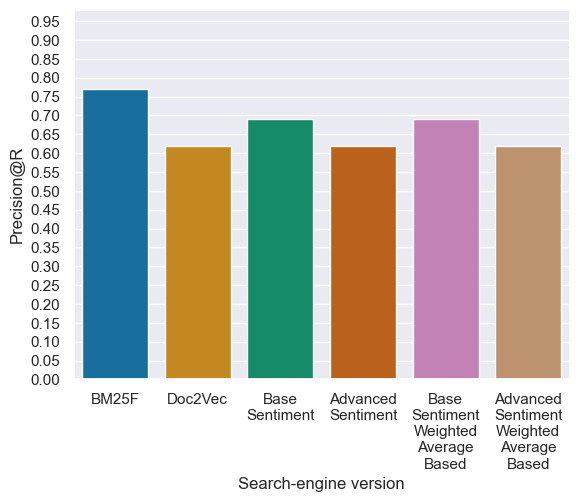

In [9]:
versions = [] 
RP_values=[]

for model, model_name in models:
    result = b.getResults(20, model)
    
    RP_values.append(b.getRPrecision(result))
    
    versions.append(textwrap.fill(model_name, width=10,
                break_long_words=True))

# plot the average precisi+ons
# apply the default theme
sns.set_theme()

# create a dataframe for Seaborn
df = pd.DataFrame({"Search-engine version": versions, 'Precision@R': RP_values})

# plot the bar graph
pltRP = sns.barplot(data = df, x = "Search-engine version", y = 'Precision@R', palette="colorblind")

# set fixed axes, the semicolon suppress the output
pltRP.set_ylim([0.0, max(AvPr_values)+0.20]); # set y-axis    
pltRP.yaxis.set_major_locator(MultipleLocator(0.05))

### Mean Average Precision (MAP)

Firstly, get Non-Interpolated Average Precision for each query using $ \sum_{r=0}^{n} \frac{P_q(r/|R_q|)}{|R_q|} $


In [10]:

NIAP_dict = {}

for q in queries:
    
    tmpB = Benchmark(q)
    
    for model, model_name in models:
        result = tmpB.getResults(20, model)
        
        NIAP_dict.setdefault(model_name, []).append(tmpB.getNIapAvgPrecision(
            tmpB.getPrecisionValues(result),
            tmpB.getRecallValues(result)
        ))


'8946230'
'11621478'
'TermRange' object has no attribute 'text'
'TermRange' object has no attribute 'text'
'TermRange' object has no attribute 'text'
'TermRange' object has no attribute 'text'
'TermRange' object has no attribute 'text'
'TermRange' object has no attribute 'text'
'7661166'
'1346531'


Secondly, compute Mean Average Precision for every model which is just an average between all the NIAP. 

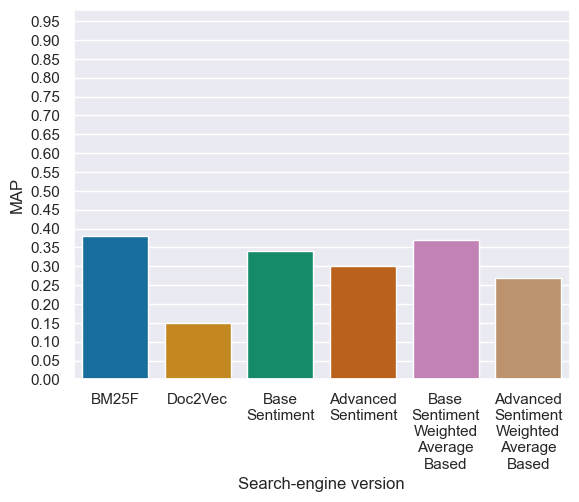

In [11]:
MAP_list = []
versions = []

for model_name, p_list in NIAP_dict.items():
    MAP_list.append(round(sum(p_list)/len(p_list),2) if len(p_list) != 0 else 0)
            
    versions.append(textwrap.fill(model_name, width=10,
                break_long_words=True))

# apply the default theme
sns.set_theme()

# create a dataframe for Seaborn
df = pd.DataFrame({"Search-engine version": versions, 'MAP': MAP_list})

# plot the bar graph
pltRP = sns.barplot(data = df, x = "Search-engine version", y = 'MAP', palette="colorblind")

# set fixed axes, the semicolon suppress the output
pltRP.set_ylim([0.0, max(AvPr_values)+0.20]); # set y-axis    
pltRP.yaxis.set_major_locator(MultipleLocator(0.05))


### F-Measure & E-Measure 

E-measure is a variant of the harmonic mean which allows us to emphasize the value of recall or precision based on what we are interested in:

- $b=1 \rightarrow 1-\text{F-Measure}$ 
- $b>1$ emphasize precision
- $b<1$ emphasize recall

*Precision or Recall?*

- High Recall: relevant documents, but with too many unrelevant documents. 
- High Precision: few results but with an greater probability of being relevant. 

It's possible to customize *b* value.

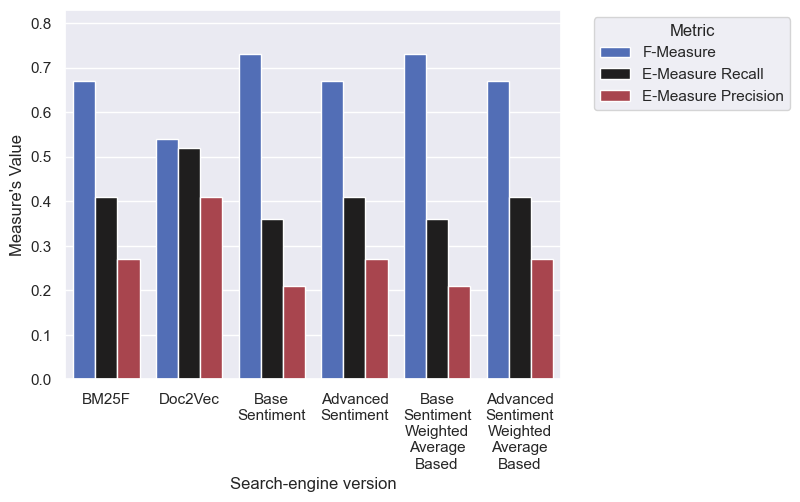

In [12]:

b_recall = 0.5          # Default value for emphasizing recall
b_precision = 1.5       # Default value for emphasizing precision

df = pd.DataFrame(columns=["Search-engine version"])
for model, model_name in models:    
    result = b.getResults(20, model)

    data = {
    'F-Measure': [b.getFMeasure(result)],
    'E-Measure Recall': [b.getEMeasure(result, b_recall)],
    'E-Measure Precision': [b.getEMeasure(result, b_precision)]
    }

    tmpDf = pd.DataFrame(data)
    tmpDf["Search-engine version"] = textwrap.fill(model_name, width=10,
                break_long_words=True)
    
    df = pd.concat([df, tmpDf])
    

# apply the default theme
sns.set_theme()

df_long = df.melt(id_vars='Search-engine version', var_name='Metric', value_name='Measure\'s Value')

# Crea il barplot
pltMeasures = sns.barplot(x='Search-engine version', y='Measure\'s Value', hue='Metric', data=df_long, palette='icefire')
pltMeasures.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')


# set fixed axes, the semicolon suppress the output
pltMeasures.set_ylim([0.0, df.iloc[:, -3:].max().max()+0.1]); # set y-axis    